This notebook decompose the model domain into regions that include the hydraulic flow (strong plunging flow) and other regions in the sills 

In [ ]:
basefile = "/scratch/bcpi/cliu28/internal-tide-mixing"
cd(basefile)

include(string(basefile, "/functions/interpolation_z_dimension.jl"))
using Interpolations
using NCDatasets
using Oceananigans
using Oceananigans.Units
function deriv(z, y)
    dydz = diff(y[:, :, :, :], dims=3) ./ reshape(diff(z[:]), 1, 1, length(zC) - 1)
    return dydz
end
function calculate_background_buoyancy(θ)
    θ = θ
    ĝ = (sin(θ), 0, cos(θ)) # the vertical unit vector in rotated coordinates
    N = 1e-3
    @inline ẑ(x, z, ĝ) = x * ĝ[1] + z * ĝ[3]
    @inline constant_stratification(x, y, z, t, p) = p.N² * ẑ(x, z, p.ĝ)

    # Create a background field
    B̄_field = BackgroundField(constant_stratification, parameters=(; ĝ, N²=N^2))

    # Setup grid
    H = 2.25kilometers # vertical extent
    Lx = 15kilometers # along-canyon extent
    Ly = 30kilometers # cross-canyon extent
    Nx = 500
    Ny = 1000
    Nz = 250

    # Bottom-intensified stretching for vertical grid
    z_faces(k) = -H * ((1 + ((Nz + 1 - k) / Nz - 1) / 1.2) *
                       (1 - exp(-15 * (Nz + 1 - k) / Nz)) / (1 - exp(-15)) - 1)

    grid = RectilinearGrid(size=(Nx, Ny, Nz),
        x=(0, Lx),
        y=(0, Ly),
        z=z_faces,
        halo=(4, 4, 4),
        topology=(Oceananigans.Periodic, Oceananigans.Periodic, Oceananigans.Bounded))

    model = NonhydrostaticModel(
        grid=grid,
        background_fields=(; b=B̄_field),
        tracers=:b
    )

    return interior(compute!(Field(model.background_fields.tracers.b)))[:, :, :]
end

simname = "tilt"
tᶠ = 460
θ = 3.6e-3
filename_hab = "output/hab.nc"
ds_hab = Dataset(filename_hab, "r")
hab = ds_hab["hab"][:, :, :];
# for mask
filename_verification = string("output/", "tilt", "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", 10, "_threeD_timeavg.nc")
ds_verification = Dataset(filename_verification, "r")
b_ver = ds_verification["b"][:, :, :, 1:1];          # buoyancy perturbation
B̄ = calculate_background_buoyancy(θ)

# define grids
zC = ds_verification["zC"][:];
zF = ds_verification["zF"][:];
Nz = length(zC[:]);

xC = ds_verification["xC"][:];
xF = ds_verification["xF"][:];
Nx = length(xC[:]);
dx = xF[end] - xF[end-1];

yC = ds_verification["yC"][:];
yF = ds_verification["yF"][:];
Ny = length(yC[:]);
dy = yF[end] - yF[end-1];
# t = ds_velocity["time"][:];


data_mode = "tidal phase average"   # "10TP average" or "tidal phase average"

if data_mode == "10TP average"
    filename_velocity = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_timeavg_const_dt_u-v-w-Rig.nc")
    ds_velocity = Dataset(filename_velocity, "r")
    filename_B = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_timeavg_B-c.nc")
    ds_B = Dataset(filename_B, "r")

    what = nanmean(ds_velocity["what"][:, :, :, :], dim=4)    # 10TP average true w
    # Interpolate each row
    what_center = zeros(size(what, 1), size(what, 2), length(zC))
    for i in 1:size(what, 1)
        for j in 1:size(what, 2)
            itp = linear_interpolation(zF[:], what[i, j, :], extrapolation_bc=Line())
            what_center[i, j, :] = itp(zC)
        end
    end
    B = nanmean(ds_B["B"][:, :, :, :], dim=4)                 # 10TP average B
    Bz = deriv(zC, B)
    Bz[b_ver[:, :, 1:end-1, 1:1].==0] .= 0      # the grids are staggered, but this will effectively set the points inside and right above the immersed boudary to 0
    # interpolate Bz from faces to center cell
    Bz_center = zeros(size(Bz, 1), size(Bz, 2), length(zC))
    for i in 1:size(Bz, 1)
        for j in 1:size(Bz, 2)
            itp = linear_interpolation(zF[2:end-1], Bz[i, j, :], extrapolation_bc=Line())
            Bz_center[i, j, :] = itp(zC)
        end
    end
    b = B .- B̄

elseif data_mode == "tidal phase average"
    filename_velocity = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_u-v-w-c.nc")
    ds_velocity = Dataset(filename_velocity, "r")
    filename_B = string("output/", simname, "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", tᶠ, "_threeD_B-c.nc")
    ds_B = Dataset(filename_B, "r")

    ni = 1:3:10
    what = zeros(Nx, Ny, Nz + 1, length(ni))
    B = zeros(Nx, Ny, Nz, length(ni))
    for n in 1:length(ni)
        if ni[n] == 1   # first tidal phase
            what[:, :, :, n] = nanmean(ds_velocity["what"][:, :, :, 12:12:120], dim=4)
            B[:, :, :, n] = nanmean(ds_B["B"][:, :, :, 12:12:120], dim=4)
        else            # the rest of the tidal phases
            for i in 1:10
                what[:, :, :, n] += ds_velocity["what"][:, :, :, 12i-(12-(ni[n]-1))]    # true w
                B[:, :, :, n] += ds_B["B"][:, :, :, 12i-(12-(ni[n]-1))]    # true B
            end
            what[:, :, :, n] ./= 10
            B[:, :, :, n] ./= 10
        end
    end
    b = B .- B̄
    b[abs.(b).<1e-15] .= 0
    Bz = deriv(zC, B)
    Bz[b[:, :, 1:end-1, :].==0] .= 0      # the grids are staggered, but this will effectively set the points inside and right above the immersed boudary to 0
    # interpolate Bz from faces to center cell
    Bz_center = zeros(size(Bz, 1), size(Bz, 2), length(zC), length(ni))
    for n in 1:length(ni)
        for i in 1:size(Bz, 1)
            for j in 1:size(Bz, 2)
                itp = linear_interpolation(zF[2:end-1], Bz[i, j, :, n], extrapolation_bc=Line())
                Bz_center[i, j, :, n] = itp(zC)
            end
        end
    end
    # Interpolate each row
    what_center = zeros(size(what, 1), size(what, 2), length(zC), length(ni))
    for n in 1:length(ni)
        for i in 1:size(what, 1)
            for j in 1:size(what, 2)
                itp = linear_interpolation(zF[:], what[i, j, :, n], extrapolation_bc=Line())
                what_center[i, j, :, n] = itp(zC)
            end
        end
    end
end




# Define dimensions based on the data mode
if data_mode == "10TP average"
    # save the data into netcdf file including what_center and Bz_center
    output_filename = string("output/", simname, "/10TP_average_w_Bz_theta=", θ, "_tᶠ=", tᶠ, ".nc")
    # Check if file exists and remove it if it does
    if isfile(output_filename)
        rm(output_filename)
        println("Removed existing file: $output_filename")
    end
    # Create a new NetCDF file
    ds_output = Dataset(output_filename, "c")
    # Define dimensions
    defDim(ds_output, "x", Nx)
    defDim(ds_output, "y", Ny)
    defDim(ds_output, "z", Nz)

    # Define variables
    v_what = defVar(ds_output, "what_center", Float64, ("x", "y", "z"))
    v_Bz = defVar(ds_output, "Bz_center", Float64, ("x", "y", "z"))
    v_b = defVar(ds_output, "b", Float64, ("x", "y", "z"))

    # Write data
    v_what[:, :, :] = what_center
    v_Bz[:, :, :] = Bz_center
    v_b[:, :, :] = b

elseif data_mode == "tidal phase average"
    output_filename = string("output/", simname, "/tidal_phase_average_w_Bz_theta=", θ, "_tᶠ=", tᶠ, ".nc")
    # Check if file exists and remove it if it does
    if isfile(output_filename)
        rm(output_filename)
        println("Removed existing file: $output_filename")
    end
    # Create a new NetCDF file
    ds_output = Dataset(output_filename, "c")
    # Define dimensions
    defDim(ds_output, "x", Nx)
    defDim(ds_output, "y", Ny)
    defDim(ds_output, "z", Nz)
    defDim(ds_output, "tidal_phase", length(ni))

    # Define variables
    v_what = defVar(ds_output, "what_center", Float64, ("x", "y", "z", "tidal_phase"))
    v_Bz = defVar(ds_output, "Bz_center", Float64, ("x", "y", "z", "tidal_phase"))

    # Write data
    v_what[:, :, :, :] = what_center
    v_Bz[:, :, :, :] = Bz_center

    # Add tidal phase information
    v_phase = defVar(ds_output, "tidal_phase", Int32, ("tidal_phase",))
    v_phase[:] = ni
end

# Add grid variables
v_xC = defVar(ds_output, "xC", Float64, ("x",))
v_yC = defVar(ds_output, "yC", Float64, ("y",))
v_zC = defVar(ds_output, "zC", Float64, ("z",))
v_xC[:] = xC
v_yC[:] = yC
v_zC[:] = zC

# Add global attributes
ds_output.attrib["data_mode"] = data_mode
ds_output.attrib["simulation"] = simname
ds_output.attrib["theta"] = θ
ds_output.attrib["tf"] = tᶠ

# Close the file
close(ds_output)
println("Data saved to: $output_filename")



┌ Error: CUDA.jl could not find an appropriate CUDA runtime to use.
│ 
│ CUDA.jl's JLLs were precompiled without an NVIDIA driver present.
│ This can happen when installing CUDA.jl on an HPC log-in node,
│ or in a container. In that case, you need to specify which CUDA
│ version to use at run time by calling `CUDA.set_runtime_version!`
│ or provisioning the preference it sets at compile time.
│ 
│ If you are not running in a container or on an HPC log-in node,
│ try re-compiling the CUDA runtime JLL and re-loading CUDA.jl:
│      pkg = Base.PkgId(Base.UUID("76a88914-d11a-5bdc-97e0-2f5a05c973a2"),
│                       "CUDA_Runtime_jll")
│      Base.compilecache(pkg)
│      # re-start Julia and re-load CUDA.jl
│ 
│ For more details, refer to the CUDA.jl documentation at
│ https://cuda.juliagpu.org/stable/installation/overview/
└ @ CUDA /u/cliu28/.julia/packages/CUDA/1kIOw/src/initialization.jl:118


Data saved to: output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460.nc


0.001

Load bathymetry

In [1]:
# load topography 
Nx = 500
Ny = 1000
Nz = 250
basefile = "/scratch/bcpi/cliu28/internal-tide-mixing"
cd(basefile)
using MAT
using Interpolations
file = matopen("topo.mat")
z_topo = read(file, "z_noslope_periodic")
x_topo = read(file, "x_domain")
y_topo = read(file, "y_domain")
# grids has to be evenly spaced
x_topo_lin = range(x_topo[1], x_topo[end], size(z_topo, 1))
y_topo_lin = range(y_topo[1], y_topo[end], size(z_topo, 2))
close(file)
# high-resolution grids
x_interp = range(x_topo[1], x_topo[end], length=Nx)
y_interp = range(y_topo[1], y_topo[end], length=Ny)


# Interpolation object (caches coefficients and such)
itp = LinearInterpolation((x_topo_lin, y_topo_lin), z_topo)
# Interpolate z_topo onto a higher-resolution grid
z_interp = [itp(x, y) for x in x_interp, y in y_interp]
z_interp = z_interp .- minimum(z_interp)

500×1000 Matrix{Float64}:
 1108.12  1109.76  1111.41  1113.05  …  1108.96  1108.68  1108.4   1108.12
 1113.52  1115.1   1116.68  1118.27     1114.41  1114.11  1113.82  1113.52
 1118.92  1120.44  1121.96  1123.48     1119.85  1119.54  1119.23  1118.92
 1124.32  1125.78  1127.24  1128.7      1125.3   1124.97  1124.64  1124.32
 1129.71  1131.12  1132.52  1133.92     1130.74  1130.4   1130.06  1129.71
 1135.11  1136.45  1137.8   1139.14  …  1136.18  1135.83  1135.47  1135.11
 1140.51  1141.79  1143.07  1144.36     1141.63  1141.25  1140.88  1140.51
 1145.91  1147.13  1148.35  1149.57     1147.07  1146.68  1146.3   1145.91
 1151.31  1152.47  1153.63  1154.79     1152.51  1152.11  1151.71  1151.31
 1156.7   1157.81  1158.91  1160.01     1157.96  1157.54  1157.12  1156.7
    ⋮                                ⋱                             
 1108.97  1110.4   1111.83  1113.26     1109.82  1109.53  1109.25  1108.97
 1108.86  1110.32  1111.78  1113.24     1109.71  1109.43  1109.14  1108.86
 1108.7

Decompose model domain into three different regions, define masks

In [13]:
# data_mode = "tidal phase average"   # "10TP average" or "tidal phase average"
data_mode = "10TP average"   # "10TP average" or "tidal phase average"
using NCDatasets

# Create a mask for elevated bathymetry in the central region
# Identify the sill by finding elevated regions near the domain center
# First, determine a reasonable threshold for the sill height
sill_height_threshold = 300
mask_bathymetry = zeros(Int, size(z_interp))
mask_bathymetry[z_interp.>sill_height_threshold] .= 1
mask_bathymetry[:, 18Ny÷30:Ny] .= 0
mask_bathymetry[:, 1:7Ny÷30] .= 0

# Create downwelling mask based on vertical velocity
if data_mode == "10TP average"
    filename_velocity = "output/tilt/10TP_average_w_Bz_theta=0.0036_tᶠ=460.nc"
    ds = Dataset(filename_velocity, "r")
    # Read the vertical velocity data
    what_center = ds["what_center"][:, :, :]
    mask_downwelling = zeros(Int, size(z_interp))
    # Create initial mask with zeros
    # Check each water column
    for i in 1:Nx
        for j in 1:Ny
            # If any point in the column meets the condition
            if any(what_center[i, j, :] .< -1e-2)
                # Mark the entire column
                mask_downwelling[i, j] = 1
            end
        end
    end

else
    filename_velocity = "output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460.nc"
    ds = Dataset(filename_velocity, "r")
    what_center = ds["what_center"][:, :, :, :]
    mask_downwelling = zeros(Nx, Ny, length(ds["tidal_phase"][:]))
    # For tidal phase average, use the first phase
    for l in 1:length(ds["tidal_phase"][:])
        for i in 1:Nx
            for j in 1:Ny
                # If any point in the column meets the condition
                if any(what_center[i, j, :, l] .< -1e-2)
                    # Mark the entire column
                    mask_downwelling[i, j, l] = 1
                end
            end
        end
        @info l
    end
end

# Combine both masks - sill is where we have both high bathymetry and strong downwelling
mask_sill = zeros(Int, size(mask_downwelling))
mask_sill = mask_downwelling .* mask_bathymetry


## Create separate masks for the north and south sills
sill_height_threshold = 830
mask_sill_bathymetry = zeros(Int, size(z_interp))
mask_sill_bathymetry[z_interp.>sill_height_threshold] .= 1

mask_north_bathymetry = copy(mask_sill_bathymetry)
mask_north_bathymetry[:, 1:18Ny÷30] .= 0
mask_south_bathymetry = copy(mask_sill_bathymetry)
mask_south_bathymetry[:, Ny÷3:Ny] .= 0


500×668 view(::Matrix{Int64}, :, 333:1000) with eltype Int64:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱              ⋮              ⋮     
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0 

Plot the regions of the three masks

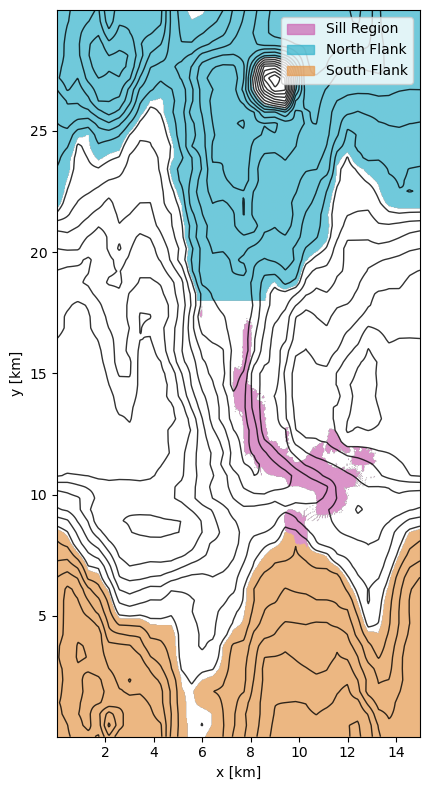

In [14]:
# Import plotting package
ds = Dataset("output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460.nc", "r")
xC = ds["xC"][:];
yC = ds["yC"][:];
using PyPlot

# Create a combined mask to visualize the three regions
combined_mask = zeros(Int, Nx, Ny)

# For 3D masks, take the maximum value along the vertical direction
sill_2d = mask_sill[:, :, 1]

# Combine the masks - ensuring the sill takes precedence
combined_mask[sill_2d.==1] .= 1
combined_mask[(sill_2d.==0).&(mask_north_bathymetry.==1)] .= 2
combined_mask[(sill_2d.==0).&(mask_south_bathymetry.==1)] .= 3
# Convert to floating point before assigning NaN
combined_mask = Float64.(combined_mask)
combined_mask[combined_mask.==0] .= NaN

fig, ax = subplots(figsize=(10, 8))

# Define a custom colormap for the regions
# Define a custom colormap with nicer colors and transparency
region_colors = [
    (0.8, 0.4, 0.7, 0.7),        # Soft purple for sill region
    (0.2, 0.7, 0.8, 0.7),        # Teal for North Flank
    (0.9, 0.6, 0.3, 0.7)         # Amber for South Flank
]
cmap = matplotlib.colors.ListedColormap(region_colors)
bounds = [1, 2, 3, 4]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Plot the mask
im = ax.imshow(combined_mask', origin="lower", extent=[xC[1], xC[end], yC[1], yC[end]] ./ 1e3,
    aspect="equal", cmap=cmap, norm=norm)

# Add bathymetry contours
contours = ax.contour(xC / 1e3, yC / 1e3, z_interp', 0:100:2200, colors="black", alpha=0.8, linewidths=1)

# Create custom legend
region_labels = ["Sill Region", "North Flank", "South Flank"]
patches = [matplotlib.patches.Patch(color=region_colors[i], label=region_labels[i]) for i in 1:3]
ax.legend(handles=patches, loc="upper right")

# Add labels and title
# ax.set_title("Domain Region Decomposition")
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")

tight_layout()
display(gcf())


Compute the hab average for each regions

In [27]:
using NCDatasets
using PyPlot
include("../functions/bins.jl")
# load hab
filename_hab = "output/hab.nc"
ds_hab = Dataset(filename_hab, "r")
hab = ds_hab["hab"][:, :, :];
bin_mask = hab;
θ = 0.0036
dx = 30
dy = 30
# Define the bin edges
bin_edge = 0:7:1500
bin_center = @. (bin_edge[1:end-1] + bin_edge[2:end]) / 2
data_mode = "tidal phase average"   # "10TP average" or "tidal phase average"
# data_mode = "10TP average"   # "10TP average" or "tidal phase average"
if data_mode == "10TP average"
    filename_velocity = "output/tilt/10TP_average_w_Bz_theta=0.0036_tᶠ=460.nc"
    ds = Dataset(filename_velocity, "r")
    # Read the vertical velocity data
    what_center = ds["what_center"][:, :, :]
    Bz_center = ds["Bz_center"][:, :, :]
else
    filename_velocity = "output/tilt/tidal_phase_average_w_Bz_theta=0.0036_tᶠ=460.nc"
    ds = Dataset(filename_velocity, "r")
    what_center = ds["what_center"][:, :, :, :]
    Bz_center = ds["Bz_center"][:, :, :, :]
end
filename_verification = string("output/", "tilt", "/internal_tide_theta=", θ, "_Nx=500_Nz=250_tᶠ=", 10, "_threeD_timeavg.nc")
ds_verification = Dataset(filename_verification, "r")
zF = ds_verification["zF"][:];

# Convert the masks to Float64 before assigning NaN values
mask_sill = Float64.(mask_sill)
mask_sill[mask_sill.==0] .= NaN

mask_north_bathymetry = Float64.(mask_north_bathymetry)
mask_north_bathymetry[mask_north_bathymetry.==0] .= NaN

mask_south_bathymetry = Float64.(mask_south_bathymetry)
mask_south_bathymetry[mask_south_bathymetry.==0] .= NaN

@time Bz_total_avg, _ = bins(Bz_center, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_total_avg, _ = bins(what_center, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
if data_mode == "tidal phase average"
    mask_sill_reshaped = reshape(mask_sill, size(mask_sill, 1), size(mask_sill, 2), 1, size(mask_sill, 3))
else
    mask_sill_reshaped = mask_sill
end
@time Bz_sill_avg, _ = bins(Bz_center .* mask_sill_reshaped, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_sill_avg, _ = bins(what_center .* mask_sill_reshaped, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time Bz_north_avg, _ = bins(Bz_center .* mask_north_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_north_avg, _ = bins(what_center .* mask_north_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time Bz_south_avg, _ = bins(Bz_center .* mask_south_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)
@time w_south_avg, _ = bins(what_center .* mask_south_bathymetry, bin_edge, bin_mask, dx=dx, dy=dy, z_face=zF, normalize=true)

 24.071627 seconds (847.21 k allocations: 18.852 GiB, 17.50% gc time, 8.84% compilation time)
 27.268375 seconds (171 allocations: 18.798 GiB, 15.50% gc time)
 12.762524 seconds (175 allocations: 14.222 GiB, 17.12% gc time)
 13.620406 seconds (175 allocations: 14.222 GiB, 17.56% gc time)
 16.643143 seconds (175 allocations: 15.596 GiB, 19.35% gc time)
 14.915040 seconds (175 allocations: 15.596 GiB, 20.50% gc time)
 15.613100 seconds (175 allocations: 15.175 GiB, 21.03% gc time)
 15.487266 seconds (175 allocations: 15.175 GiB, 21.41% gc time)


([-0.0010053839997219574 -0.0006318742888679463 -0.0012476126830419793 -0.0012650254790574928; -0.0016338096630880783 -0.0009613748573624879 -0.0021922518470513567 -0.002195478304423121; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], 3.5:7.0:1494.5)

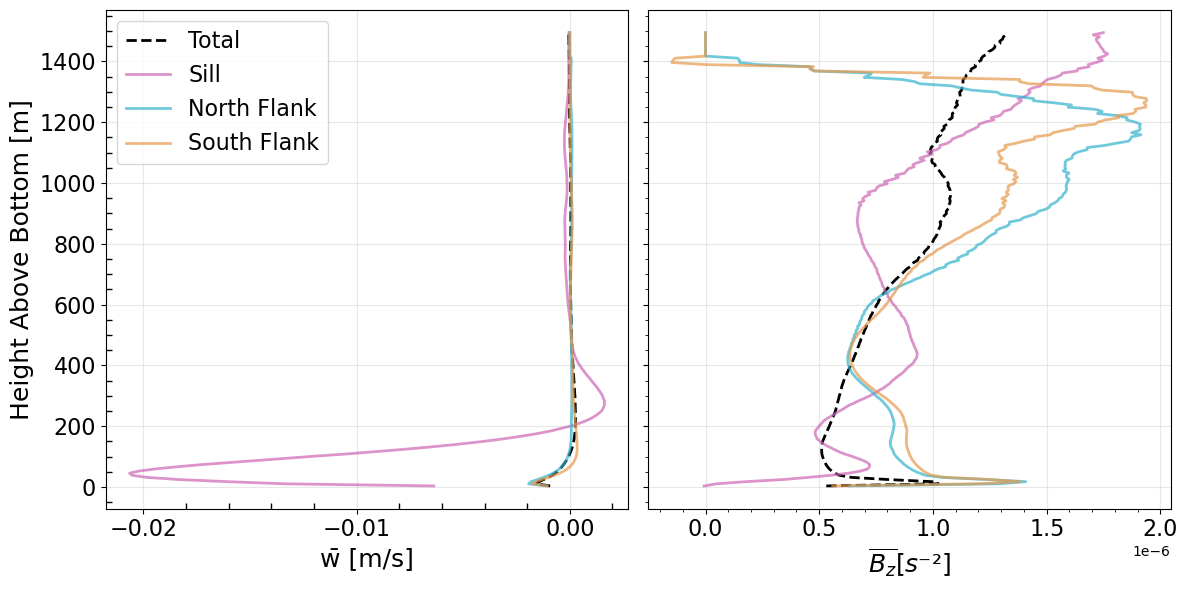

In [26]:
if data_mode == "10TP average"
    # Create figure with two subplots
    region_colors = [
        (0.8, 0.4, 0.7, 0.7),        # Soft purple for sill region
        (0.2, 0.7, 0.8, 0.7),        # Teal for North Flank
        (0.9, 0.6, 0.3, 0.7)         # Amber for South Flank
    ]
    fig, ax = PyPlot.subplots(1, 2, figsize=(12, 6), sharey=true)

    # Plot vertical velocity (w)
    ax[1].plot(w_total_avg[:], bin_center, label="Total", linewidth=2, color="black", linestyle="--")
    ax[1].plot(w_sill_avg, bin_center, label="Sill", linewidth=2, color=region_colors[1])
    ax[1].plot(w_north_avg, bin_center, label="North Flank", linewidth=2, color=region_colors[2])
    ax[1].plot(w_south_avg, bin_center, label="South Flank", linewidth=2, color=region_colors[3])
    ax[1].set_xlabel("w̄ [m/s]", fontsize=18)
    ax[1].set_ylabel("Height Above Bottom [m]", fontsize=18)
    ax[1].grid(true, alpha=0.3)
    ax[1].tick_params(axis="both", which="major", labelsize=16)
    ax[1].set_xticks(-0.02:0.01:0.005)  # Fewer ticks
    ax[1].minorticks_on()  # Enable minor ticks
    ax[1].tick_params(axis="both", which="minor", length=4, width=1, color="black", direction="in")
    # Plot vertical buoyancy gradient (Bz)
    ax[2].plot(Bz_total_avg, bin_center, label="Total", linewidth=2, color="black", linestyle="--")
    ax[2].plot(Bz_sill_avg, bin_center, label="Sill", linewidth=2, color=region_colors[1])
    ax[2].plot(Bz_north_avg, bin_center, label="North Flank", linewidth=2, color=region_colors[2])
    ax[2].plot(Bz_south_avg, bin_center, label="South Flank", linewidth=2, color=region_colors[3])
    ax[2].set_xlabel(L"\overline{B_z} [s⁻²]", fontsize=18)
    # axes[2].set_title("Vertical Buoyancy Gradient", fontsize=20)
    ax[2].grid(true, alpha=0.3)
    ax[2].minorticks_on()  # Enable minor ticks
    ax[2].tick_params(axis="both", which="major", labelsize=16)
    ax[1].legend(fontsize=16)

    tight_layout()
    display(gcf())
end

Plot tidal phase average at each regions. Soft to strong colors indicates tidal phase 1/12, 4/12, 7/12, and 10/12

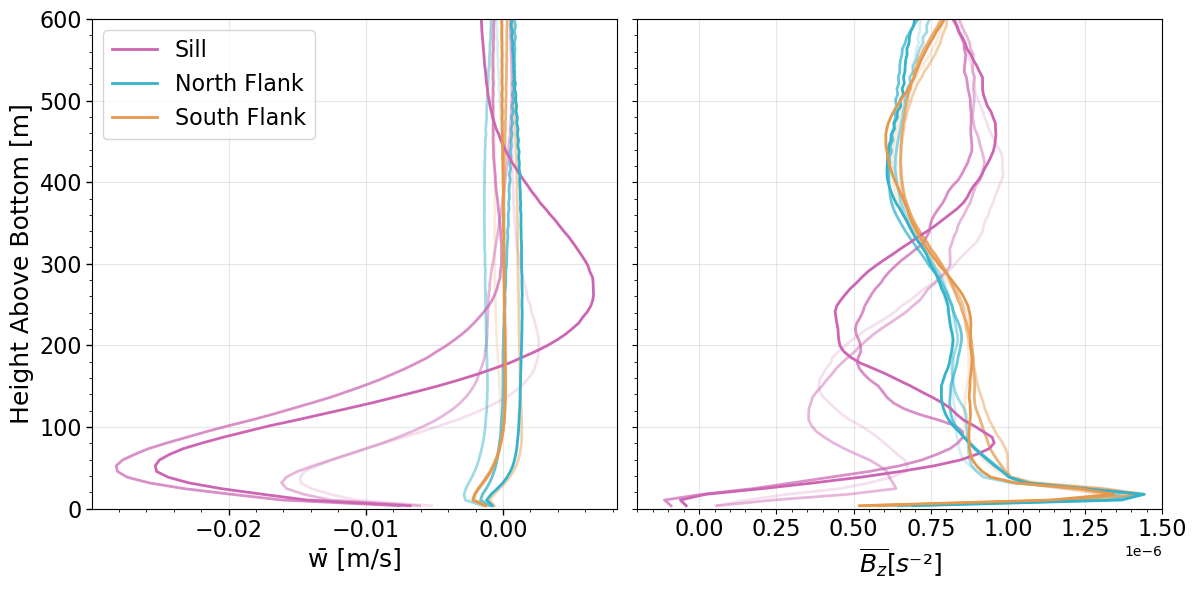

In [29]:
using PyPlot 
if data_mode == "tidal phase average"
    # Create figure with two subplots
    region_colors = [
        (0.8, 0.4, 0.7),        # Base purple for sill region
        (0.2, 0.7, 0.8),        # Base teal for North Flank
        (0.9, 0.6, 0.3)         # Base amber for South Flank
    ]
    n_times = size(w_sill_avg, 2)
    alphas = range(0.2, 1.0, length=n_times)  # From soft to strong

    fig, ax = PyPlot.subplots(1, 2, figsize=(12, 6), sharey=true)

    # Plot w profiles for each region and time
    for t in 1:n_times
        ax[1].plot(w_sill_avg[:, t], bin_center, color=region_colors[1], alpha=alphas[t], linewidth=2, label=t==n_times ? "Sill" : "")
        ax[1].plot(w_north_avg[:, t], bin_center, color=region_colors[2], alpha=alphas[t], linewidth=2, label=t==n_times ? "North Flank" : "")
        ax[1].plot(w_south_avg[:, t], bin_center, color=region_colors[3], alpha=alphas[t], linewidth=2, label=t==n_times ? "South Flank" : "")
    end
    ax[1].set_xlabel("w̄ [m/s]", fontsize=18)
    ax[1].set_ylabel("Height Above Bottom [m]", fontsize=18)
    ax[1].grid(true, alpha=0.3)
    ax[1].tick_params(axis="both", which="major", labelsize=16)
    ax[1].set_xticks(-0.02:0.01:0.005)
    ax[1].minorticks_on()
    ax[1].tick_params(axis="both", which="major", length=4, width=1, color="black", direction="out")
    ax[1].legend(fontsize=16)
    ax[1].set_ylim(0,600)

    # Plot Bz profiles for each region and time
    for t in 1:n_times
        ax[2].plot(Bz_sill_avg[:, t], bin_center, color=region_colors[1], alpha=alphas[t], linewidth=2, label=t==n_times ? "Sill" : "")
        ax[2].plot(Bz_north_avg[:, t], bin_center, color=region_colors[2], alpha=alphas[t], linewidth=2, label=t==n_times ? "North Flank" : "")
        ax[2].plot(Bz_south_avg[:, t], bin_center, color=region_colors[3], alpha=alphas[t], linewidth=2, label=t==n_times ? "South Flank" : "")
    end
    ax[2].set_xlabel(L"\overline{B_z} [s⁻²]", fontsize=18)
    ax[2].grid(true, alpha=0.3)
    ax[2].minorticks_on()
    ax[2].tick_params(axis="both", which="major", labelsize=16)
    ax[2].set_ylim(0,600)
    ax[2].set_xlim(-0.2e-6,1.5e-6)
    tight_layout()
    display(gcf())
end